In [2]:
import pickle
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from network import BiRNN, RNN
from visualization import variance_and_bias_analysis, plot_confusion_matrix, show, save, data_visual
from data_optimization import dimension_reduce, normalization, intra_iteration
from data_augmentation import crop
import datetime

In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 0  # this parameter will be renewed in 'dataloader' function
input_size = 36  # including 6 channels of 6 IMU sensors, totally 36 channels
hidden_size = 256  # parameters for LSTM (Long Short Term Memory)
num_layers = 2  # the depth of Deep-RNNs
num_classes = 4
batch_size = 48
num_epochs = 60
learning_rate = 0.01

# Test parameters
RANDOM_SEED_NUM = 0
TRIALS_NUM = 5
LABELS = ['right_standing', 'wrong_standing', 'right_turning', 'wrong_turning']
DATASET_NAME = 'dataset.pkl'


def data_load():

    dataset_name0 = 'lin'
    dataset_name1 = 'zhong'
    actions = LABELS
    pkl_file = open(DATASET_NAME, 'rb')
    dataset = pickle.load(pkl_file)
    pkl_file.close()
    dataset0 = dataset[dataset_name0]
    dataset1 = dataset[dataset_name1]

    # get longest time length among different actions
    max_t = max(dataset0['length_range'][1], dataset1['length_range'][1])
    global sequence_length
    sequence_length = max_t  # the longest length of sample

    # divide the dataset into train set, dev set and test set
    x_train, y_train, x_dev, y_dev, x_test, y_test = [], [], [], [], [], []
    for label, action in enumerate(actions):

        # lin
        labels = [label] * len(dataset0[action])
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(dataset0[action], labels, test_size=0.4, random_state=RANDOM_SEED_NUM)
        x_train += temp_train_x
        y_train += temp_train_y
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(temp_test_x, temp_test_y, test_size=0.5, random_state=RANDOM_SEED_NUM)
        x_dev += temp_train_x
        y_dev += temp_train_y
        x_test += temp_test_x
        y_test +=temp_test_y

        # zhong
        labels = [label] * len(dataset1[action])
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(dataset1[action], labels, test_size=0.4, random_state=RANDOM_SEED_NUM)
        x_train += temp_train_x
        y_train += temp_train_y
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(temp_test_x, temp_test_y, test_size=0.5, random_state=RANDOM_SEED_NUM)
        x_dev += temp_train_x
        y_dev += temp_train_y
        x_test += temp_test_x
        y_test += temp_test_y

    # data augmentation
    x_train, y_train = crop(x_train, y_train)

    # pad the data samples
    for i in range(len(x_train)):
        x_train[i] = \
            np.pad(x_train[i][:, 1:], ((0, max_t - x_train[i].shape[0]), (0, 0)), 'constant', constant_values=0)
    for i in range(len(x_dev)):
        x_dev[i] = \
            np.pad(x_dev[i][:, 1:], ((0, max_t - x_dev[i].shape[0]), (0, 0)), 'constant', constant_values=0)
    for i in range(len(x_test)):
        x_test[i] = \
            np.pad(x_test[i][:, 1:], ((0, max_t - x_test[i].shape[0]), (0, 0)), 'constant', constant_values=0)
    
    # Intra-iteration
    x_train = intra_iteration(x_train)
    x_dev = intra_iteration(x_dev)
    x_test = intra_iteration(x_test)
    print(x_train[0].shape)
    
    # update longest time length among different actions
    sequence_length = x_train[0].shape[0]  # the longest length of sample
    
    # shuffle
    x_train, y_train = shuffle(x_train, y_train, random_state=RANDOM_SEED_NUM+1)
    x_dev, y_dev = shuffle(x_dev, y_dev, random_state=RANDOM_SEED_NUM+2)
    x_test, y_test = shuffle(x_test, y_test, random_state=RANDOM_SEED_NUM+3)

    # change dataset's data format
    x_train, y_train = \
        torch.from_numpy(np.array(x_train)).type(torch.FloatTensor),\
        torch.from_numpy(np.array(y_train)).type(torch.LongTensor)
    x_dev, y_dev = \
        torch.from_numpy(np.array(x_dev)).type(torch.FloatTensor),\
        torch.from_numpy(np.array(y_dev)).type(torch.LongTensor)
    x_test, y_test = \
        torch.from_numpy(np.array(x_test)).type(torch.FloatTensor),\
        torch.from_numpy(np.array(y_test)).type(torch.LongTensor)

    return x_train, y_train, x_dev, y_dev, x_test, y_test


def training_model(num):
    # torch.manual_seed(RANDOM_SEED_NUM)

    # Load the dataset
    X_training, Y_training, X_dev, Y_dev, X_test, Y_test = data_load()
    
    # Record losses, accuracies and labels for drawing analysis figures
    training_losses = []
    test_accuracies = []
    y_true = []
    y_pred = []

    # Create the model
    model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss() # Cross Entropy Loss funtion
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimzer

    # Create Pytorch's dataloader for training, valid and test dataset
    train_dataset = TensorDataset(X_training, Y_training)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataset = TensorDataset(X_dev, Y_dev)
    dev_loader = DataLoader(dev_dataset)
    test_dataset = TensorDataset(X_test, Y_test)
    test_loader = DataLoader(test_dataset)

    # Start training the model
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.reshape(-1).to(device)
            # Forward pass
            outputs = model(inputs)
            training_loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()
            
        # Print information, collect the training loss and valid accuracy for every 2 epoches
        if (epoch + 1) % 2 == 0:
            # Print information
            print('Test [{}], Epoch [{}/{}], Loss: {:.4f}'
                  .format(num+1, epoch + 1, num_epochs, training_loss.item()))
            # Get the value of loss
            training_losses.append(training_loss.item())
            # Test the model on valid dataset
            with torch.no_grad():
                y_true = []
                y_pred = []
                correct = 0
                total = 0
                for j, (inputs, labels) in enumerate(dev_loader):
                    inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                    labels = labels.reshape(-1).to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    y_true.append(labels.item())
                    y_pred.append(predicted.item())
                test_accuracies.append(correct/total)

    # Print accuracy of the model
    accuracy = test_accuracies[-1]*100
    print('Dev accuracy of the No.{} model on dev action samples: {} %'.format(num+1, accuracy))

    # Show or save the graph of variance and bias analysis, and confusion matrix graph
    variance_and_bias_analysis([training_losses], [test_accuracies])
    save('trials' + str(num+1) + '_loss_accuracy' + '.png')
    plot_confusion_matrix([y_true], [y_pred], LABELS)
    save('trials_' + str(num+1) + '_confusion_matrix' + '.png')

    return accuracy, model, test_loader


def test_model(model, test_loader):
    # Test the model on test set
    with torch.no_grad():
        y_true = []
        y_pred = []
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.reshape(-1).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.append(labels.item())
            y_pred.append(predicted.item())
        
        accuracy = (correct/total)*100
        print('Final accuracy is {} %'.format(accuracy))
        
        plot_confusion_matrix([y_true], [y_pred], LABELS)
        save('test_confusion_matrix' + '.png')

    # Save the modal checkpoint
    torch.save(model.state_dict(), 'DeepNAR_model.ckpt')
    return accuracy


def main(num):
    accuracylist = []
    modellist = []
    for i in range(num):
        accuracy, model, test_loader = training_model(i)
        accuracylist.append(accuracy)
        modellist.append(model)
    index = accuracylist.index(max(accuracylist))
    print('Choose No.{} model as test model with {} % Dev accuracy.'.format(index+1, max(accuracylist)))
    best_model = modellist[index]
    test_accuracy = test_model(best_model, test_loader)
    
    return test_accuracy 

(528, 36)
Test [1], Epoch [2/60], Loss: 1.3844
Test [1], Epoch [4/60], Loss: 1.4141
Test [1], Epoch [6/60], Loss: 1.4233
Test [1], Epoch [8/60], Loss: 1.3907
Test [1], Epoch [10/60], Loss: 1.4952
Test [1], Epoch [12/60], Loss: 1.4417
Test [1], Epoch [14/60], Loss: 1.4108
Test [1], Epoch [16/60], Loss: 1.3962
Test [1], Epoch [18/60], Loss: 1.3933
Test [1], Epoch [20/60], Loss: 1.4168
Test [1], Epoch [22/60], Loss: 1.4077
Test [1], Epoch [24/60], Loss: 1.4016
Test [1], Epoch [26/60], Loss: 1.4064
Test [1], Epoch [28/60], Loss: 1.4075
Test [1], Epoch [30/60], Loss: 1.4380
Test [1], Epoch [32/60], Loss: 1.4223
Test [1], Epoch [34/60], Loss: 1.3957
Test [1], Epoch [36/60], Loss: 1.4427
Test [1], Epoch [38/60], Loss: 1.3946
Test [1], Epoch [40/60], Loss: 1.4305
Test [1], Epoch [42/60], Loss: 1.5363
Test [1], Epoch [44/60], Loss: 1.4569
Test [1], Epoch [46/60], Loss: 1.4068
Test [1], Epoch [48/60], Loss: 1.3863
Test [1], Epoch [50/60], Loss: 1.4069
Test [1], Epoch [52/60], Loss: 1.4152
Test [

Test [2], Epoch [48/60], Loss: 1.4582
Test [2], Epoch [50/60], Loss: 1.3123
Test [2], Epoch [52/60], Loss: 1.3792
Test [2], Epoch [54/60], Loss: 1.3889
Test [2], Epoch [56/60], Loss: 1.3308
Test [2], Epoch [58/60], Loss: 1.4156
Test [2], Epoch [60/60], Loss: 1.3090
Dev accuracy of the No.2 model on dev action samples: 15.625 %
(528, 36)
Test [3], Epoch [2/60], Loss: 1.3487
Test [3], Epoch [4/60], Loss: 1.4406
Test [3], Epoch [6/60], Loss: 1.4467
Test [3], Epoch [8/60], Loss: 1.3234
Test [3], Epoch [10/60], Loss: 1.3856
Test [3], Epoch [12/60], Loss: 1.4192
Test [3], Epoch [14/60], Loss: 1.3803
Test [3], Epoch [16/60], Loss: 1.3889
Test [3], Epoch [18/60], Loss: 1.2051
Test [3], Epoch [20/60], Loss: 0.7873
Test [3], Epoch [22/60], Loss: 0.8863
Test [3], Epoch [24/60], Loss: 0.7775
Test [3], Epoch [26/60], Loss: 0.7015
Test [3], Epoch [28/60], Loss: 0.5929
Test [3], Epoch [30/60], Loss: 0.4575
Test [3], Epoch [32/60], Loss: 0.2762
Test [3], Epoch [34/60], Loss: 0.1470
Test [3], Epoch [36

/home/zhong/anaconda3/envs/DeepNAR/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Choose No.3 model as test model with 84.375 % Dev accuracy.
Final accuracy is 75.0 %
(528, 36)
Test [1], Epoch [2/60], Loss: 1.3901
Test [1], Epoch [4/60], Loss: 1.3976
Test [1], Epoch [6/60], Loss: 1.7873
Test [1], Epoch [8/60], Loss: 1.3746
Test [1], Epoch [10/60], Loss: 1.4470
Test [1], Epoch [12/60], Loss: 1.3524
Test [1], Epoch [14/60], Loss: 1.3769
Test [1], Epoch [16/60], Loss: 1.3284
Test [1], Epoch [18/60], Loss: 1.1157
Test [1], Epoch [20/60], Loss: 0.9812
Test [1], Epoch [22/60], Loss: 0.9164
Test [1], Epoch [24/60], Loss: 0.7337
Test [1], Epoch [26/60], Loss: 0.7071
Test [1], Epoch [28/60], Loss: 0.4805
Test [1], Epoch [30/60], Loss: 0.1892
Test [1], Epoch [32/60], Loss: 0.1122
Test [1], Epoch [34/60], Loss: 0.0607
Test [1], Epoch [36/60], Loss: 0.0422
Test [1], Epoch [38/60], Loss: 0.0940
Test [1], Epoch [40/60], Loss: 0.3681
Test [1], Epoch [42/60], Loss: 0.0906
Test [1], Epoch [44/60], Loss: 0.2070
Test [1], Epoch [46/60], Loss: 0.1515
Test [1], Epoch [48/60], Loss: 0.04

Test [2], Epoch [44/60], Loss: 1.3918
Test [2], Epoch [46/60], Loss: 1.4194
Test [2], Epoch [48/60], Loss: 1.3927
Test [2], Epoch [50/60], Loss: 1.4426
Test [2], Epoch [52/60], Loss: 1.5069
Test [2], Epoch [54/60], Loss: 1.4012
Test [2], Epoch [56/60], Loss: 1.3809
Test [2], Epoch [58/60], Loss: 1.3894
Test [2], Epoch [60/60], Loss: 1.4248
Dev accuracy of the No.2 model on dev action samples: 25.0 %
(528, 36)
Test [3], Epoch [2/60], Loss: 1.5873
Test [3], Epoch [4/60], Loss: 1.3940
Test [3], Epoch [6/60], Loss: 1.5871
Test [3], Epoch [8/60], Loss: 1.9209
Test [3], Epoch [10/60], Loss: 1.6332
Test [3], Epoch [12/60], Loss: 1.2916
Test [3], Epoch [14/60], Loss: 1.3858
Test [3], Epoch [16/60], Loss: 1.1485
Test [3], Epoch [18/60], Loss: 1.1136
Test [3], Epoch [20/60], Loss: 1.1049
Test [3], Epoch [22/60], Loss: 1.0751
Test [3], Epoch [24/60], Loss: 1.1353
Test [3], Epoch [26/60], Loss: 1.0808
Test [3], Epoch [28/60], Loss: 0.9396
Test [3], Epoch [30/60], Loss: 0.9703
Test [3], Epoch [32/6

Test [4], Epoch [26/60], Loss: 1.3921
Test [4], Epoch [28/60], Loss: 1.3938
Test [4], Epoch [30/60], Loss: 1.4207
Test [4], Epoch [32/60], Loss: 1.3873
Test [4], Epoch [34/60], Loss: 1.3939
Test [4], Epoch [36/60], Loss: 1.4118
Test [4], Epoch [38/60], Loss: 1.3973
Test [4], Epoch [40/60], Loss: 1.4087
Test [4], Epoch [42/60], Loss: 1.3908
Test [4], Epoch [44/60], Loss: 1.3897
Test [4], Epoch [46/60], Loss: 1.3897
Test [4], Epoch [48/60], Loss: 1.3851
Test [4], Epoch [50/60], Loss: 1.4006
Test [4], Epoch [52/60], Loss: 1.3890
Test [4], Epoch [54/60], Loss: 1.4055
Test [4], Epoch [56/60], Loss: 1.3959
Test [4], Epoch [58/60], Loss: 1.3924
Test [4], Epoch [60/60], Loss: 1.4015
Dev accuracy of the No.4 model on dev action samples: 25.0 %
(528, 36)
Test [5], Epoch [2/60], Loss: 1.4070
Test [5], Epoch [4/60], Loss: 1.3999
Test [5], Epoch [6/60], Loss: 1.3754
Test [5], Epoch [8/60], Loss: 1.3991
Test [5], Epoch [10/60], Loss: 1.3953
Test [5], Epoch [12/60], Loss: 1.3839
Test [5], Epoch [14/6

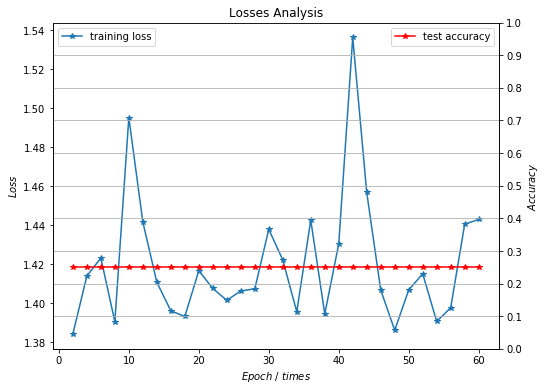

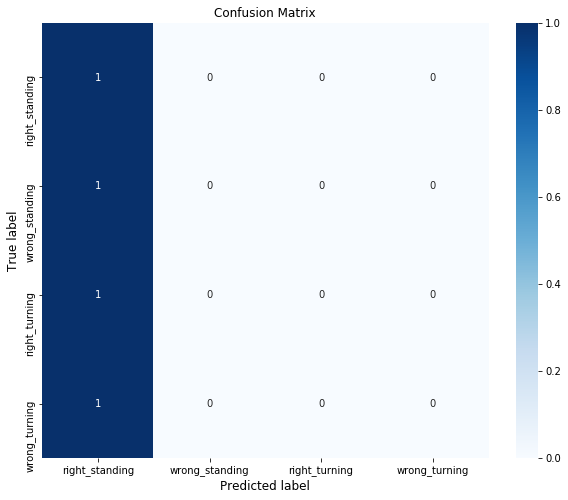

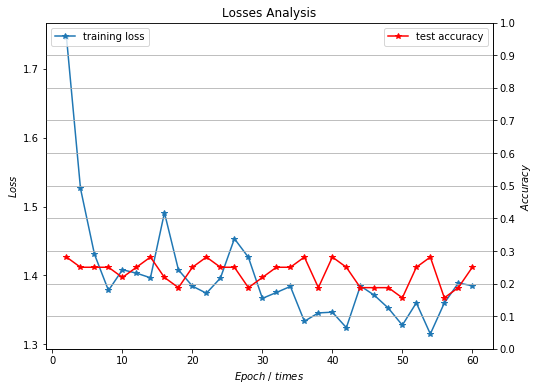

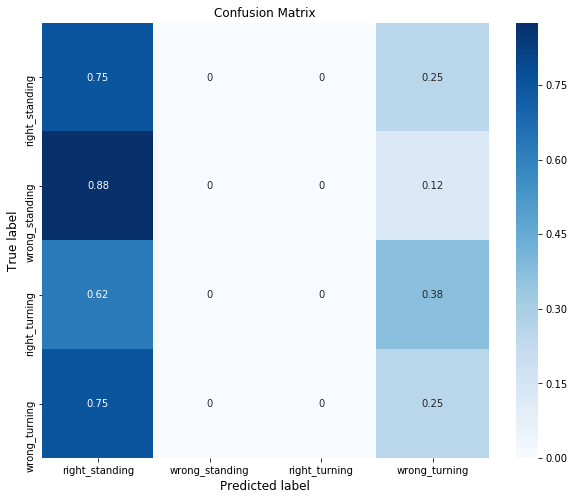

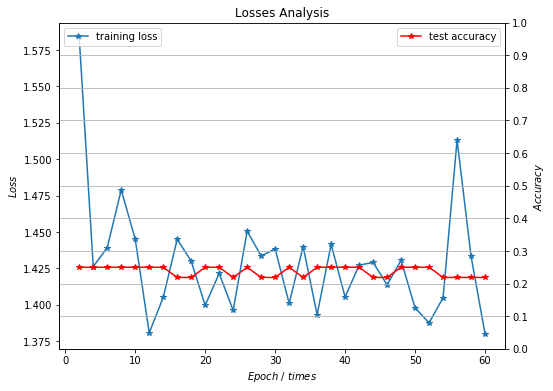

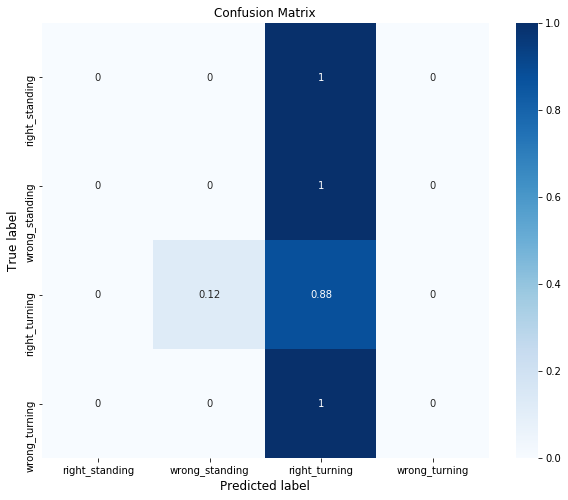

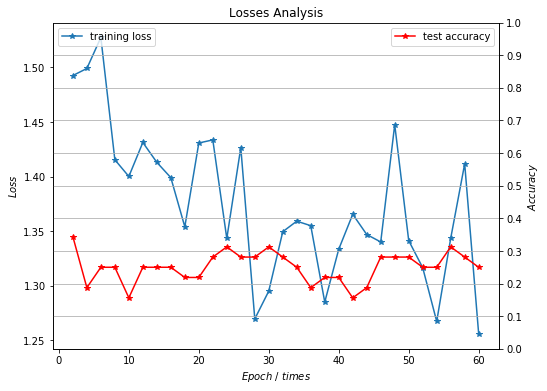

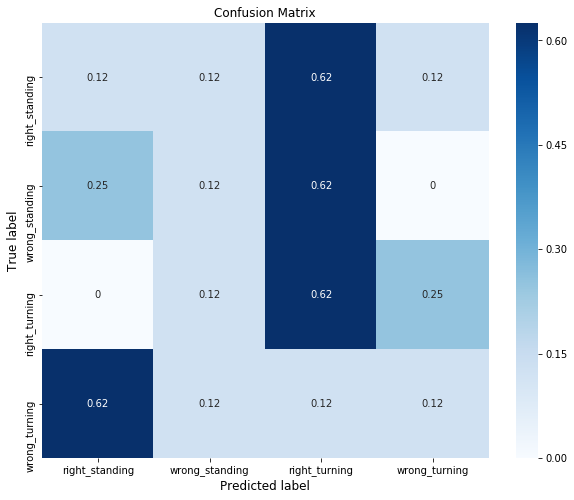

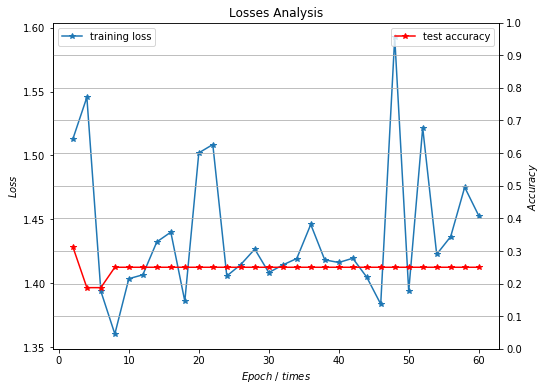

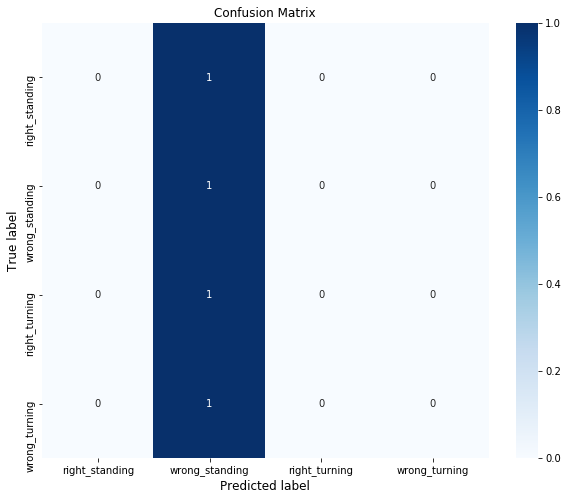

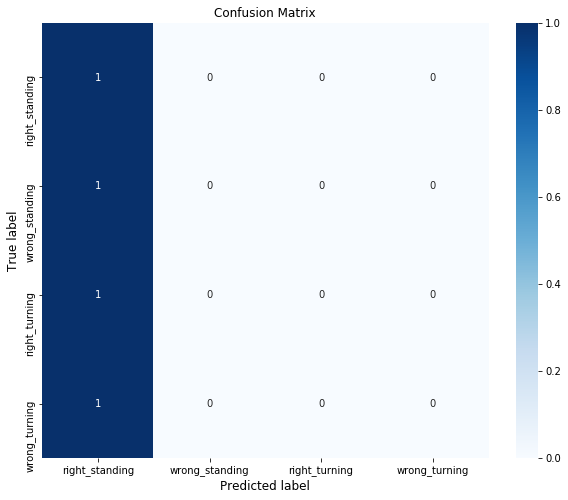

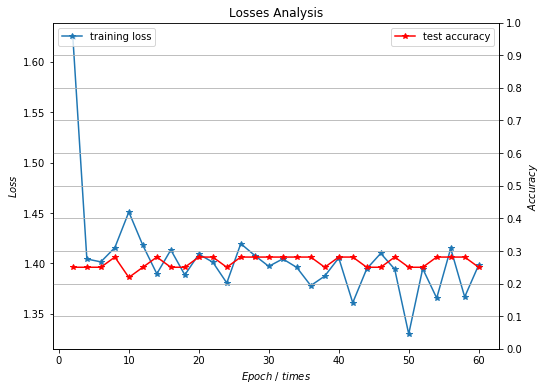

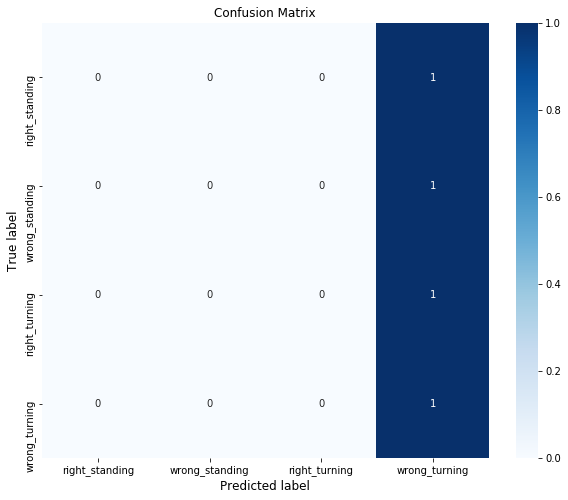

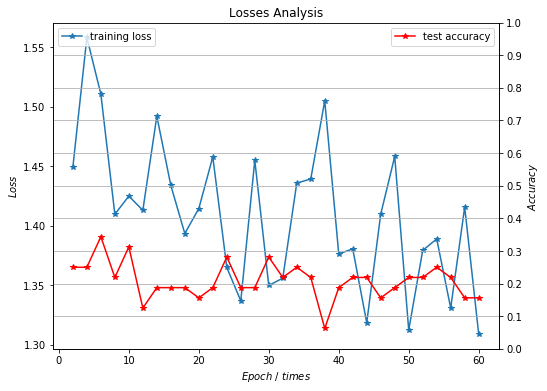

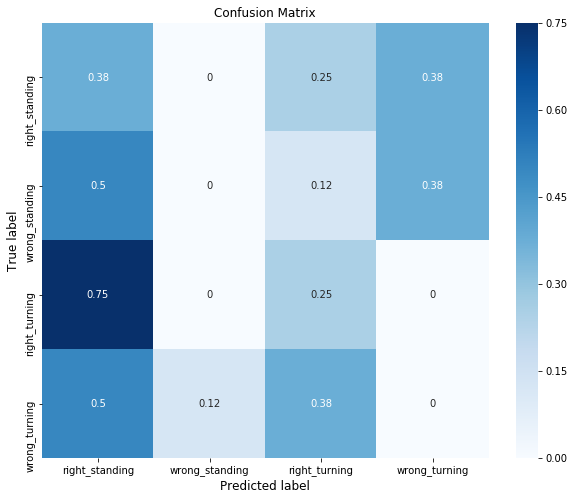

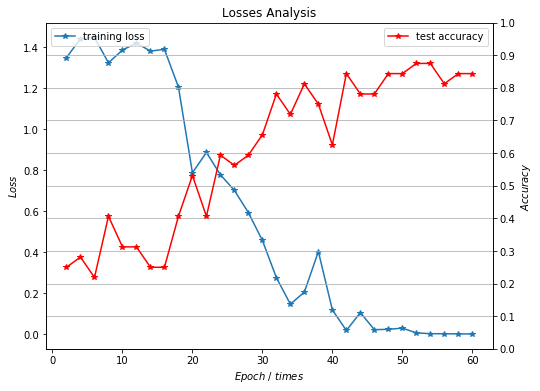

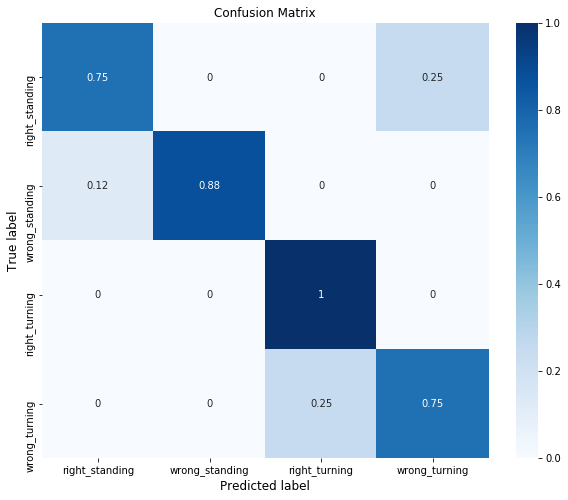

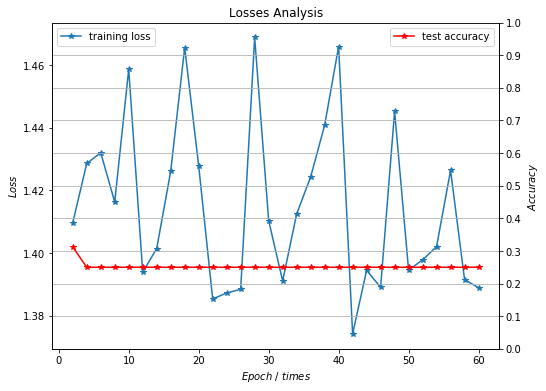

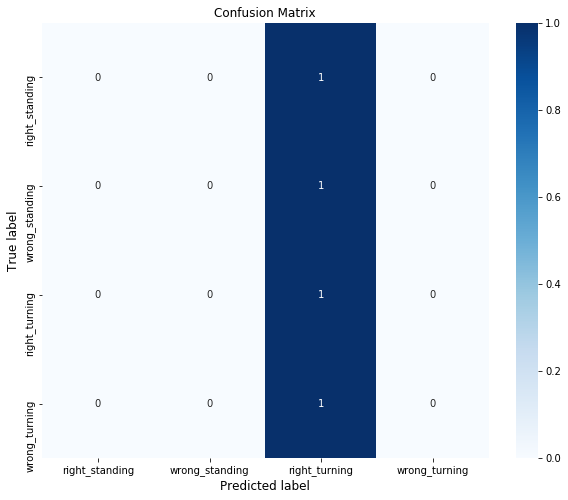

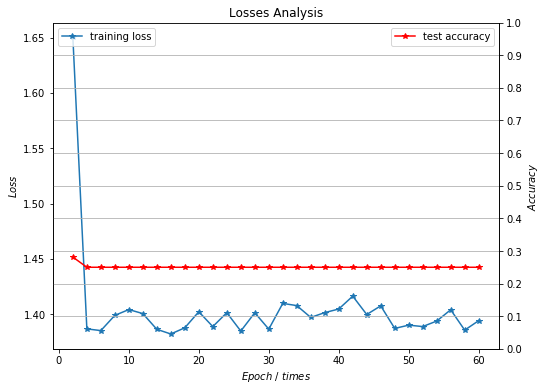

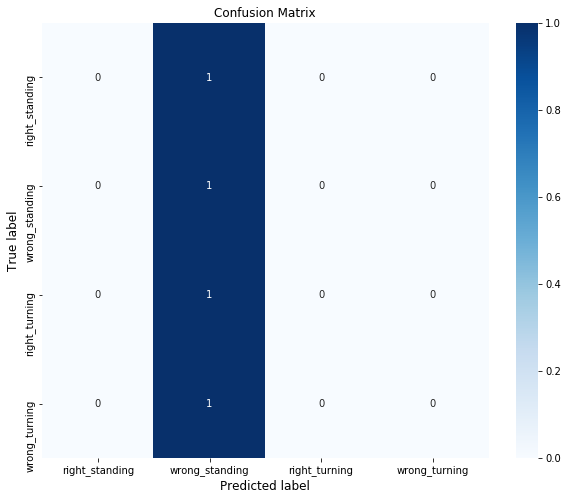

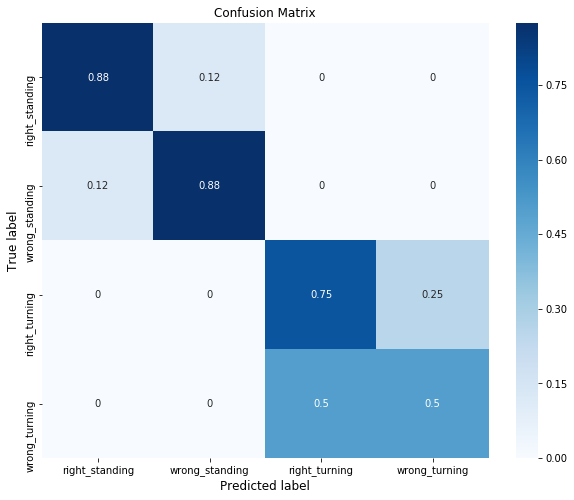

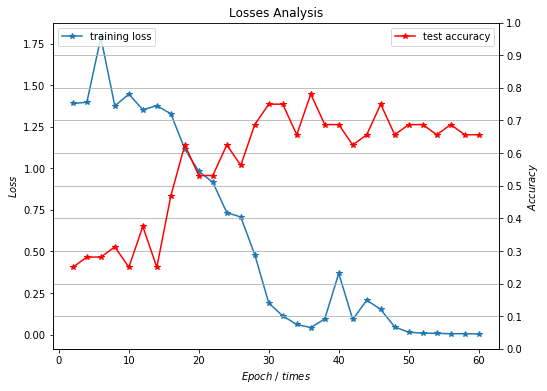

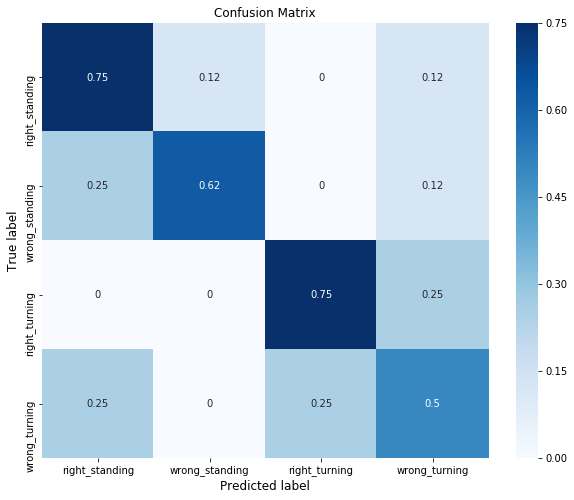

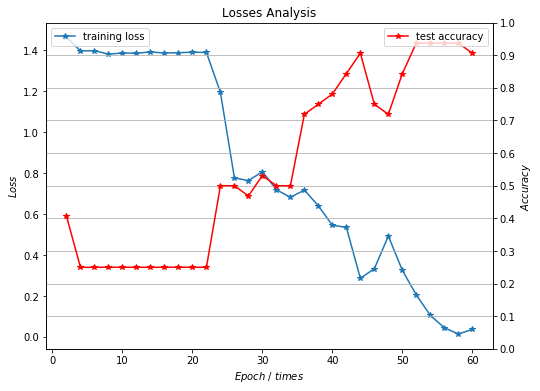

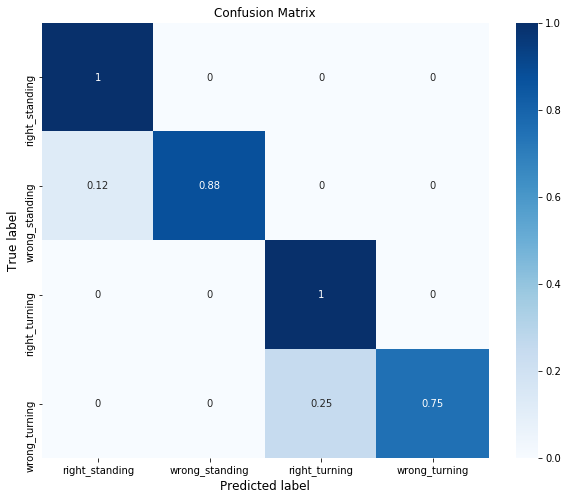

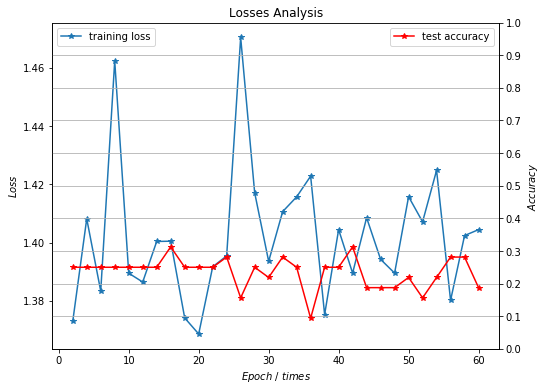

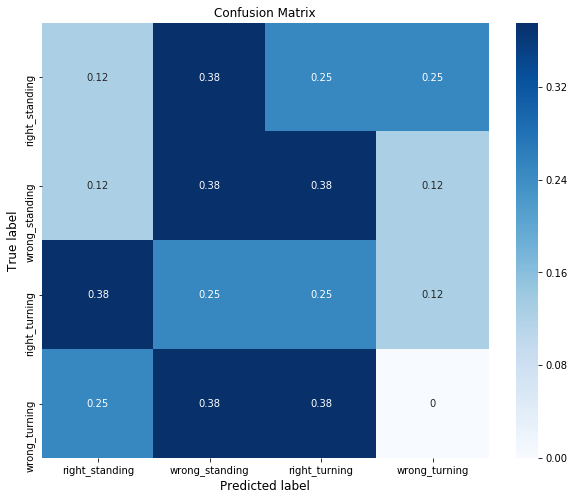

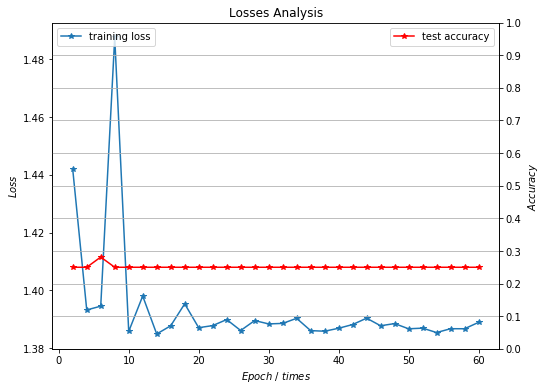

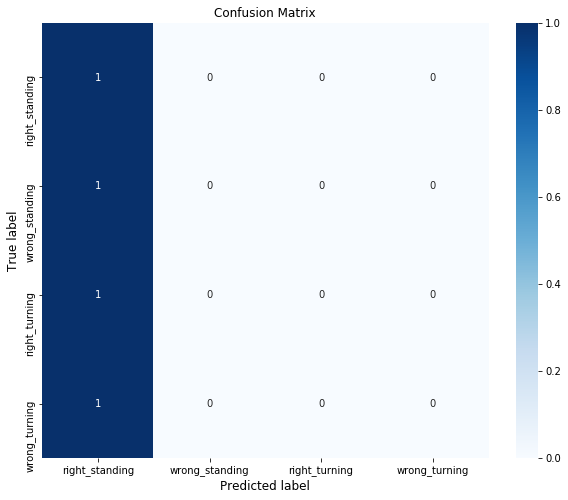

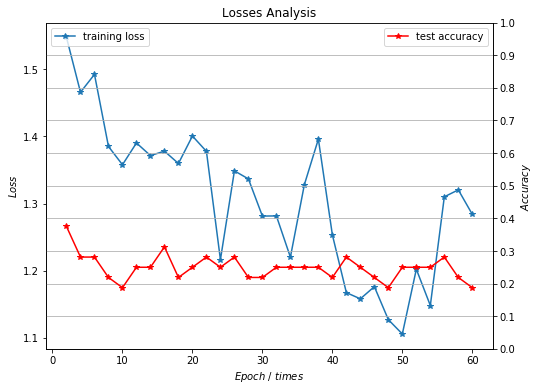

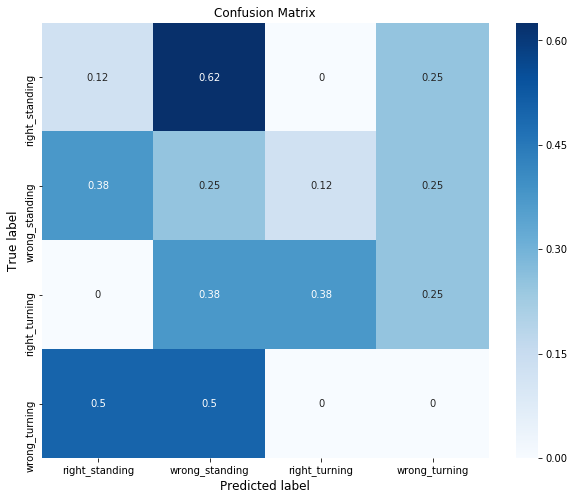

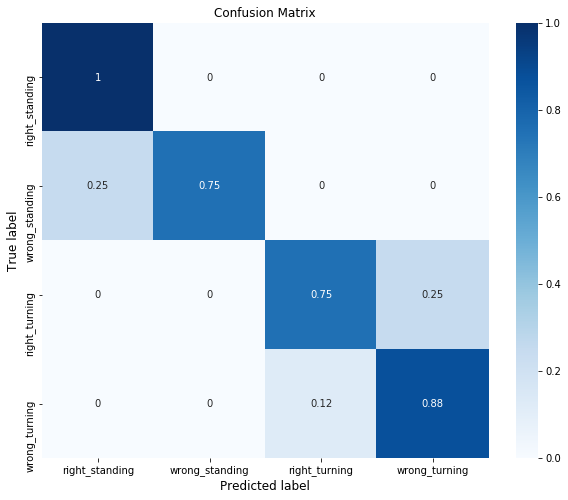

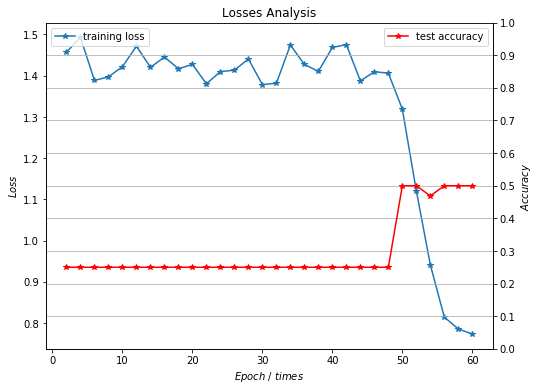

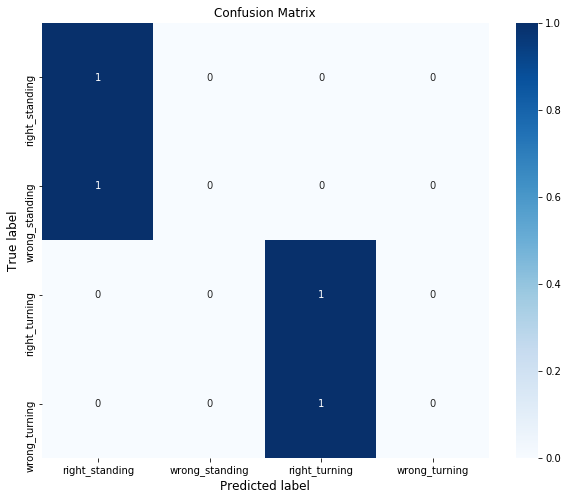

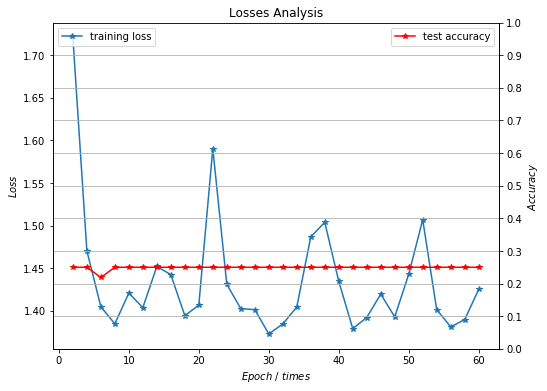

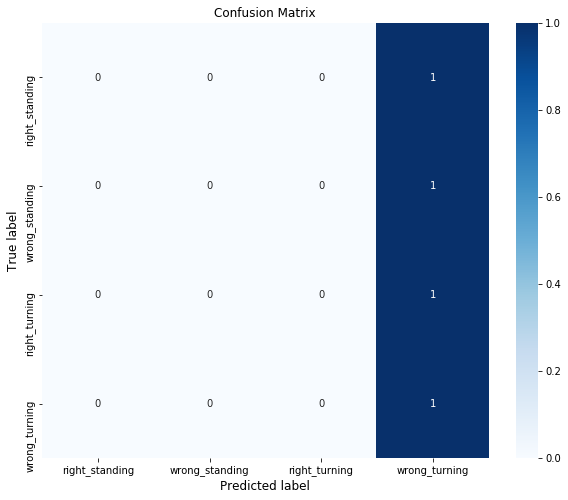

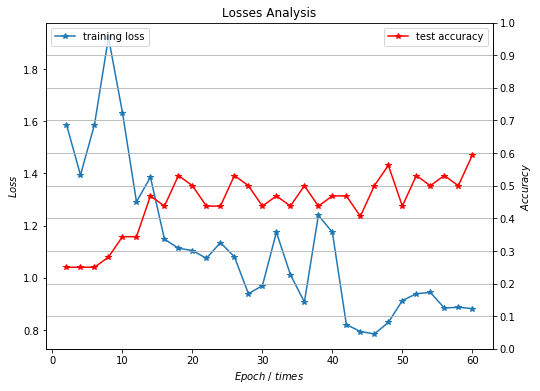

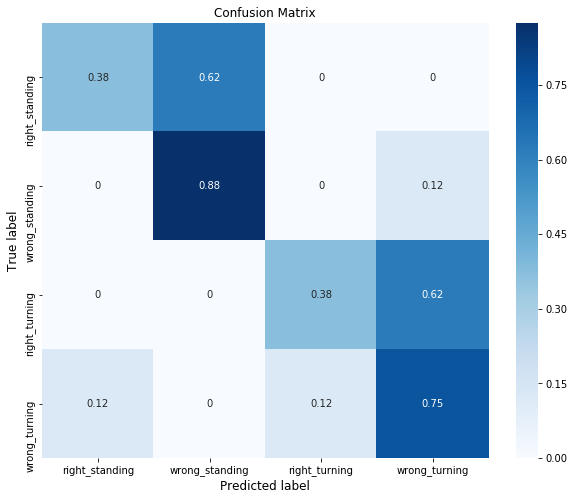

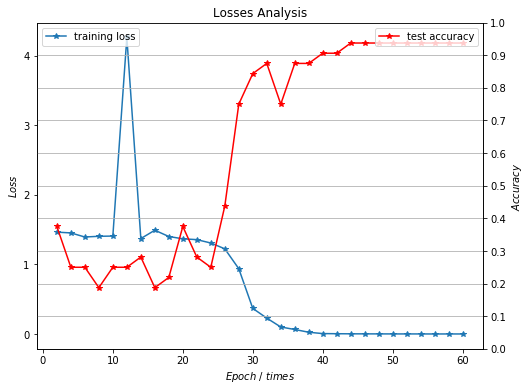

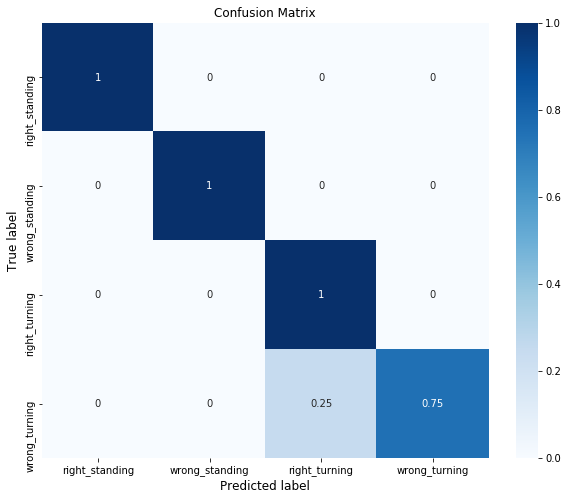

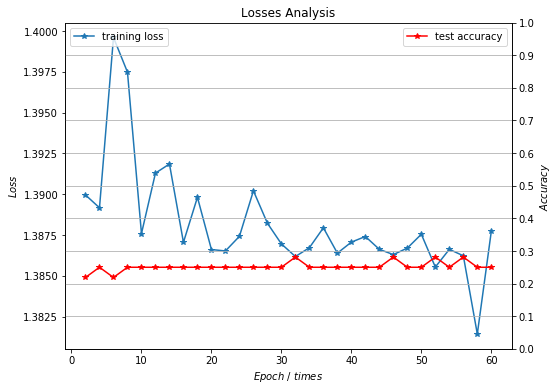

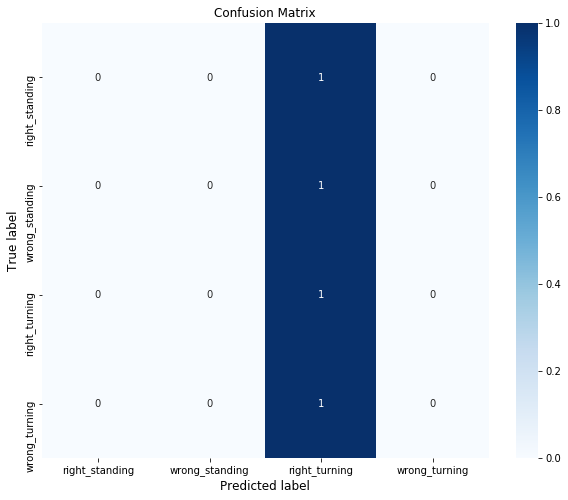

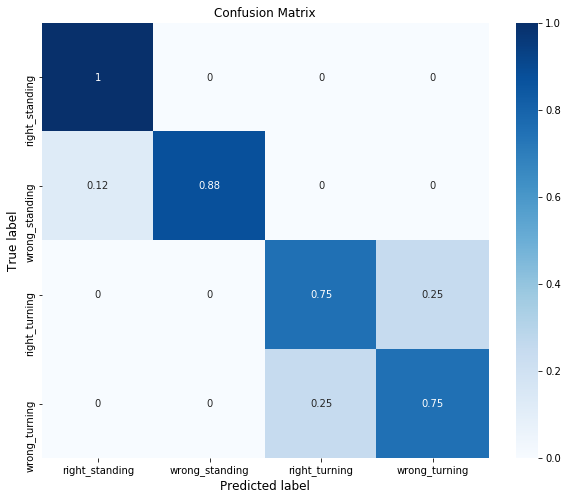

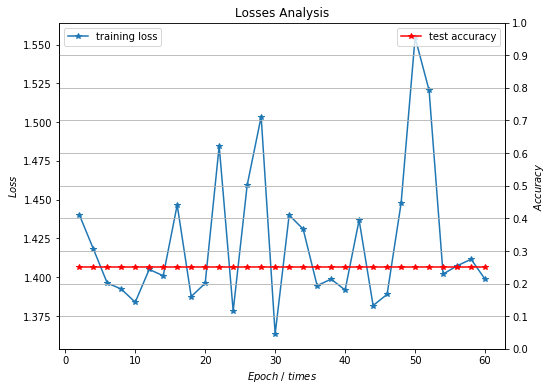

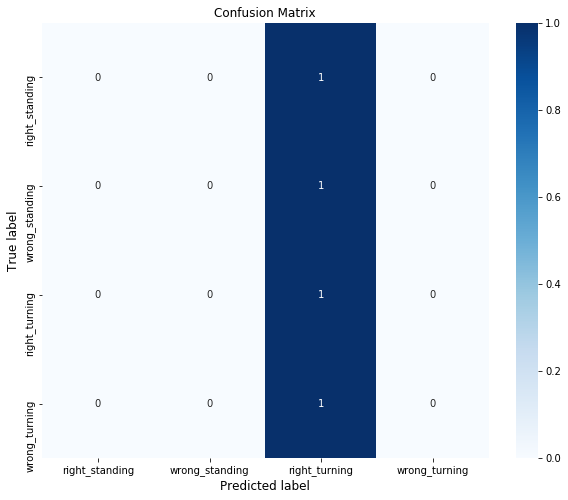

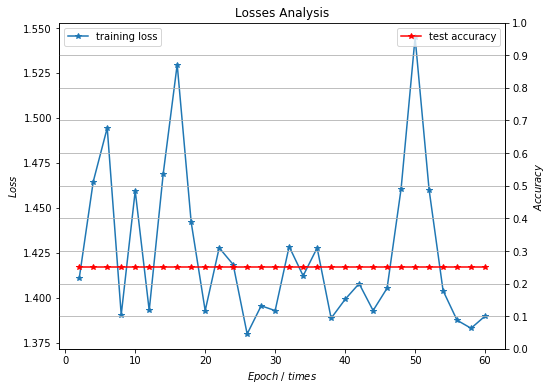

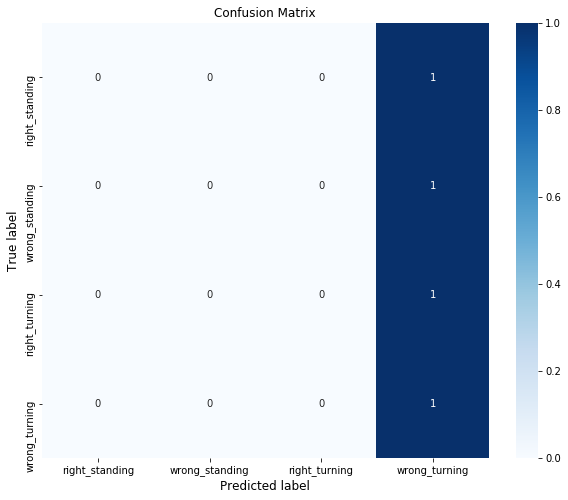

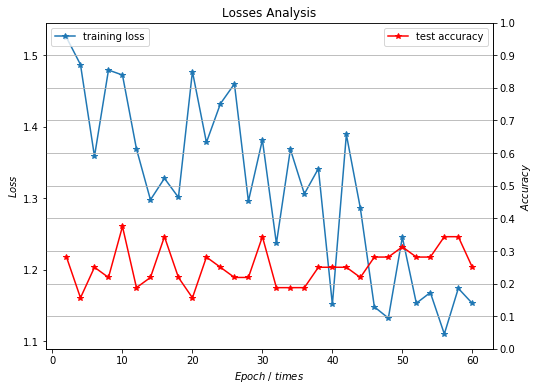

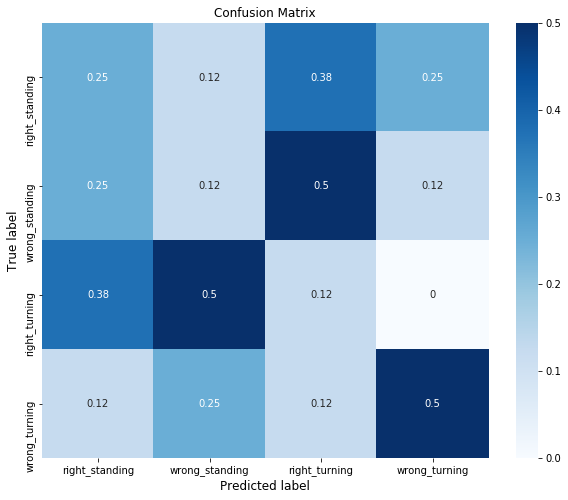

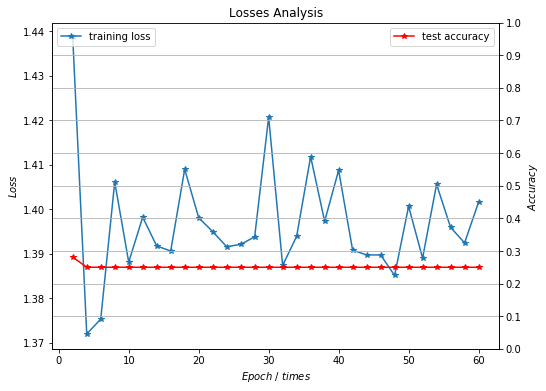

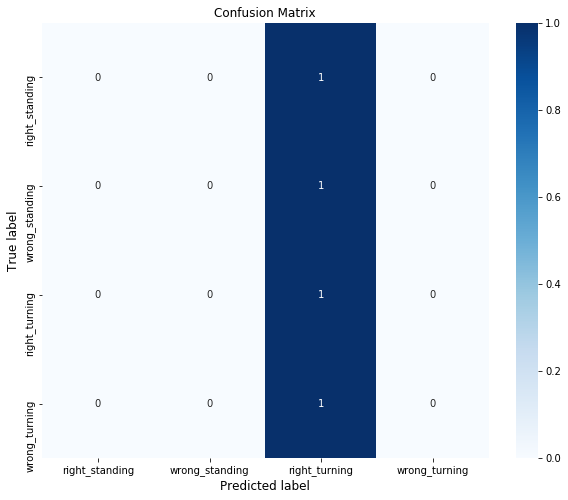

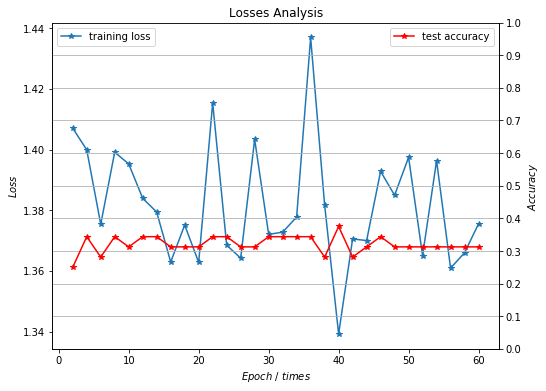

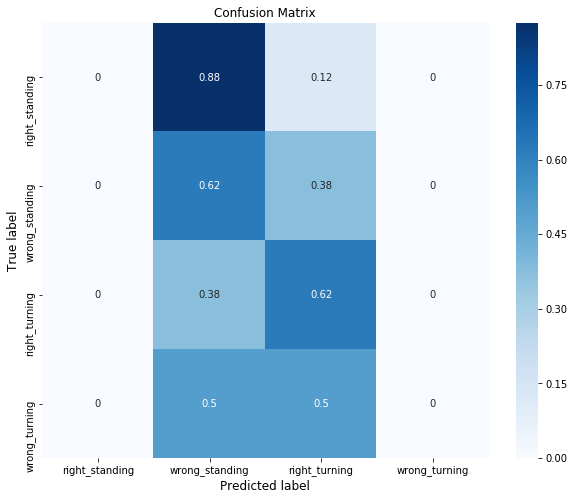

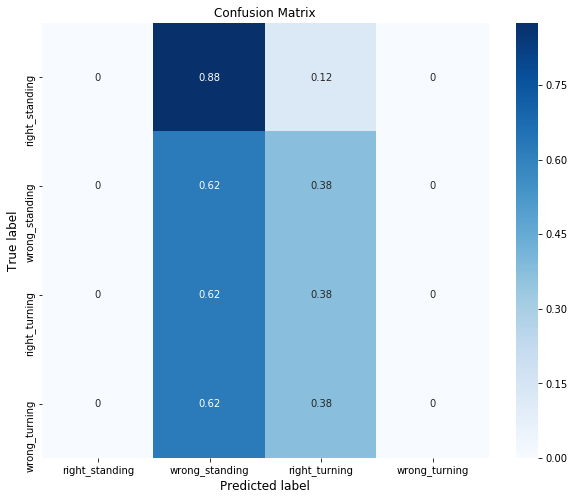

In [16]:
test_num = 5
test_accuracies = []
start = datetime.datetime.now()
for i in range(test_num):
    accuracy = main(num=TRIALS_NUM)
    test_accuracies.append(accuracy)
end = datetime.datetime.now()
print('[Cost Time]: total - {}s, each - {}s'.format(end-start, (end-start)/test_num))
print('{} times average accuracy - {}%'.format(test_num, max(test_accuracies)))

In [13]:
print(test_accuracies)

[None, None, None, None, None]
